<a href="https://colab.research.google.com/github/JonFillip/lung_pathosis_classification/blob/main/chest_xray_classification_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: John Phillip A

In [1]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from pathlib import Path
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import os
import glob
import random
import warnings
from tensorflow import keras
from matplotlib.lines import Line2D
from google.colab.patches import cv2_imshow
from google.colab import drive, files
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
warnings.filterwarnings("ignore")

In [4]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
PATH = "/content/drive/My Drive/Colab Notebooks/chest_xray/"   

def fetch_xray_data(path=PATH):
  if os.path.exists(PATH):
    print('directory already exists')
  else:
    os.makedirs(PATH)
    upload = files.upload()

  # change directory to 'grape'
  %cd /content/drive/My Drive/Colab Notebooks/chest_xray/


fetch_xray_data()

directory already exists
/content/drive/My Drive/Colab Notebooks/chest_xray


In [6]:
import os

def extract_images(chest_xray_path):
    # Initialize empty lists to store file paths
    train_data = []
    test_data = []

    # Loop through subfolders and extract image file paths
    for subfolder in ['PNEUMONIA', 'NORMAL', 'COVID19']:
        train_subfolder_path = os.path.join(chest_xray_path, 'train', subfolder)
        test_subfolder_path = os.path.join(chest_xray_path, 'test', subfolder)

        # Append file paths to train and test lists
        for image_filename in os.listdir(train_subfolder_path):
            train_data.append(os.path.join(train_subfolder_path, image_filename))

        for image_filename in os.listdir(test_subfolder_path):
            test_data.append(os.path.join(test_subfolder_path, image_filename))
    
    return train_data, test_data


In [7]:
train_set, test_set = extract_images(PATH)

In [8]:
import random

def plot_train_images(train_data):
    
    fig = plt.figure(figsize=(12, 4))

    # Select 3 random NORMAL images
    normal_indices = random.sample([i for i, path in enumerate(train_data) if 'NORMAL' in path], 3)

    # Select 3 random PNEUMONIA images
    pneumonia_indices = random.sample([i for i, path in enumerate(train_data) if 'PNEUMONIA' in path], 3)

    # Select 3 random COVID19 images
    covid19_indices = random.sample([i for i, path in enumerate(train_data) if 'COVID19' in path], 3)

    # Plot images
    for i, idx in enumerate(normal_indices):
        # Load image
        img = mpimg.imread(train_data[idx])
        # Plot image and label
        ax = fig.add_subplot(3, 9, i+1)
        ax.imshow(img, cmap='gray')
        ax.set_title('Normal')
        ax.axis('off')

    for i, idx in enumerate(pneumonia_indices):
        # Load image
        img = mpimg.imread(train_data[idx])
        # Plot image and label
        ax = fig.add_subplot(3, 9, i+4)
        ax.imshow(img, cmap='gray')
        ax.set_title('Pneumonia')
        ax.axis('off')

    for i, idx in enumerate(covid19_indices):
        # Load image
        img = mpimg.imread(train_data[idx])
        # Plot image and label
        ax = fig.add_subplot(3, 9, i+10)
        ax.imshow(img, cmap='gray')
        ax.set_title('Covid19')
        ax.axis('off')

    # Show plot
    plt.show()

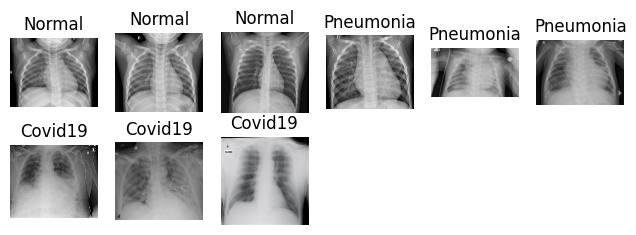

In [9]:
plot_train_images(train_set)

In [10]:
import random

def plot_train_images(test_data):
  
    fig = plt.figure(figsize=(12, 4))

    # Select 3 random NORMAL images
    normal_indices = random.sample([i for i, path in enumerate(test_data) if 'NORMAL' in path], 3)

    # Select 3 random PNEUMONIA images
    pneumonia_indices = random.sample([i for i, path in enumerate(test_data) if 'PNEUMONIA' in path], 3)

    # Select 3 random COVID19 images
    covid19_indices = random.sample([i for i, path in enumerate(test_data) if 'COVID19' in path], 3)

    # Plot images
    for i, idx in enumerate(normal_indices):
        # Load image
        img = mpimg.imread(test_data[idx])
        # Plot image and label
        ax = fig.add_subplot(2, 9, i+1)
        ax.imshow(img, cmap='gray')
        ax.set_title('Normal')
        ax.axis('off')

    for i, idx in enumerate(pneumonia_indices):
        # Load image
        img = mpimg.imread(test_data[idx])
        # Plot image and label
        ax = fig.add_subplot(2, 9, i+4)
        ax.imshow(img, cmap='gray')
        ax.set_title('Pneumonia')
        ax.axis('off')

    for i, idx in enumerate(covid19_indices):
        # Load image
        img = mpimg.imread(test_data[idx])
        # Plot image and label
        ax = fig.add_subplot(2, 9, i+10)
        ax.imshow(img, cmap='gray')
        ax.set_title('Covid19')
        ax.axis('off')

    # Show plot
    plt.show()

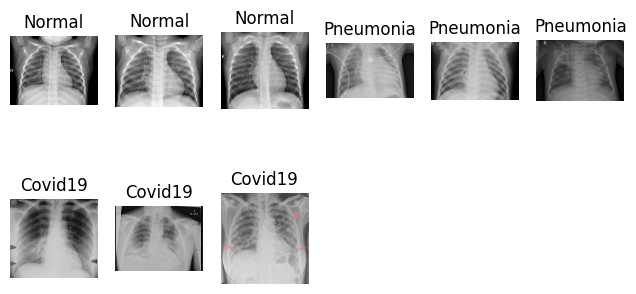

In [11]:
plot_train_images(test_set)

In [12]:
print(f"Number of images in train data: {len(train_set)}")
print(f"Number of images in test data: {len(test_set)}")


Number of images in train data: 5245
Number of images in test data: 1288


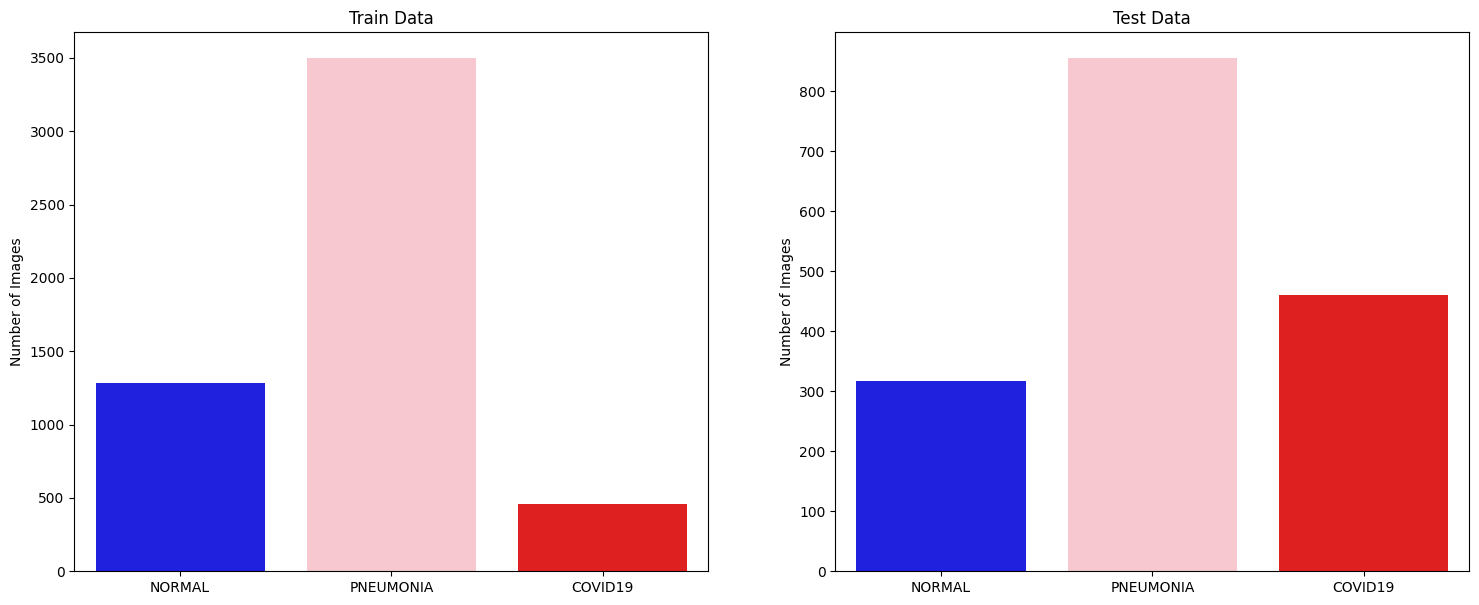

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Define paths to train and test data directories
train_path = PATH + 'train'
test_path = PATH + 'test'

# Get number of images in each category for train data
train_pneumonia_dir = os.path.join(train_path, 'PNEUMONIA')
train_normal_dir = os.path.join(train_path, 'NORMAL')
train_covid_dir = os.path.join(train_path, 'COVID19')
num_train_pneumonia = len(os.listdir(train_pneumonia_dir))
num_train_normal = len(os.listdir(train_normal_dir))
num_train_covid = len(os.listdir(train_covid_dir))

# Get number of images in each category for test data
test_pneumonia_dir = os.path.join(test_path, 'PNEUMONIA')
test_normal_dir = os.path.join(test_path, 'NORMAL')
test_covid_dir = os.path.join(test_path, 'COVID19')
num_test_pneumonia = len(os.listdir(test_pneumonia_dir))
num_test_normal = len(os.listdir(test_normal_dir))
num_test_covid = len(os.listdir(test_covid_dir))

# Create subplot for train data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,7))

sns.barplot(x=['NORMAL', 'PNEUMONIA', 'COVID19'], y=[num_train_normal, num_train_pneumonia, num_train_covid], palette=['blue', 'pink', 'red'], ax=ax1)
ax1.set(title='Train Data', ylabel='Number of Images')

# Create subplot for test data
sns.barplot(x=['NORMAL', 'PNEUMONIA', 'COVID19'], y=[num_test_normal, num_test_pneumonia, num_train_covid], palette=['blue', 'pink', 'red'], ax=ax2)
ax2.set(title='Test Data', ylabel='Number of Images')

plt.show()

In [14]:
import pathlib
import tensorflow as tf

BATCH_SIZE = 16
img_size = (224, 224)
label_map = {'NORMAL': 0, 'PNEUMONIA': 1, 'COVID19': 2}

# Load train data from list of images
train_data = []
train_labels = []
for folder in label_map.keys():
    folder_path = Path(train_path) / folder
    img_paths = [folder_path / img_file for img_file in os.listdir(folder_path)]
    img_arrays = [img_to_array(load_img(img_path, target_size=img_size)) for img_path in img_paths]
    train_data += img_arrays[:400]
    train_labels += [label_map[folder]]*400
        
# Convert train data to numpy arrays
train_data = np.array(train_data)
train_labels = np.array(train_labels)
train_labels = to_categorical(train_labels)

# Load test data from list of images
test_data = []
test_labels = []
for folder in label_map.keys():
    folder_path = Path(test_path) / folder
    img_paths = [folder_path / img_file for img_file in os.listdir(folder_path)]
    for img_path in img_paths:
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img)
        test_data.append(img_array)
        test_labels.append(label_map[folder])

# Convert test data to numpy arrays
test_data = np.array(test_data)
test_labels = np.array(test_labels)
test_labels = to_categorical(test_labels)

In [15]:
print(len(train_data))

1200


In [16]:
print(len(train_labels))

1200


In [17]:
train_labels.shape

(1200, 3)

In [18]:
def plot_loss_and_accuracy(history):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # Plot the model loss
    ax[0].plot(history.history['loss'], label='train_loss')
    ax[0].plot(history.history['val_loss'], label='val_loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].set_title('Model Loss')

    # Plot the model accuracy
    ax[1].plot(history.history['accuracy'], label='train_accuracy')
    ax[1].plot(history.history['val_accuracy'], label='val_accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].set_title('Model Accuracy')

    plt.show()

## ResNet50V2

Fold 1
94668760/94668760 [==============================] - 5s 0us/step
Epoch 1/5
25/25 [==============================] - 69s 1s/step - loss: 2.7172 - accuracy: 0.6800 - val_loss: 2.6511 - val_accuracy: 0.7750
Epoch 2/5
25/25 [==============================] - 13s 511ms/step - loss: 2.1628 - accuracy: 0.9438 - val_loss: 2.3392 - val_accuracy: 0.9050
Epoch 3/5
25/25 [==============================] - 11s 451ms/step - loss: 2.0465 - accuracy: 0.9600 - val_loss: 2.3906 - val_accuracy: 0.8950
Epoch 4/5
25/25 [==============================] - 13s 517ms/step - loss: 2.0021 - accuracy: 0.9625 - val_loss: 2.2031 - val_accuracy: 0.9200
Epoch 5/5
13/13 [==============================] - 4s 288ms/step - loss: 2.0359 - accuracy: 0.9575
Validation accuracy for fold 1: 0.9574999809265137


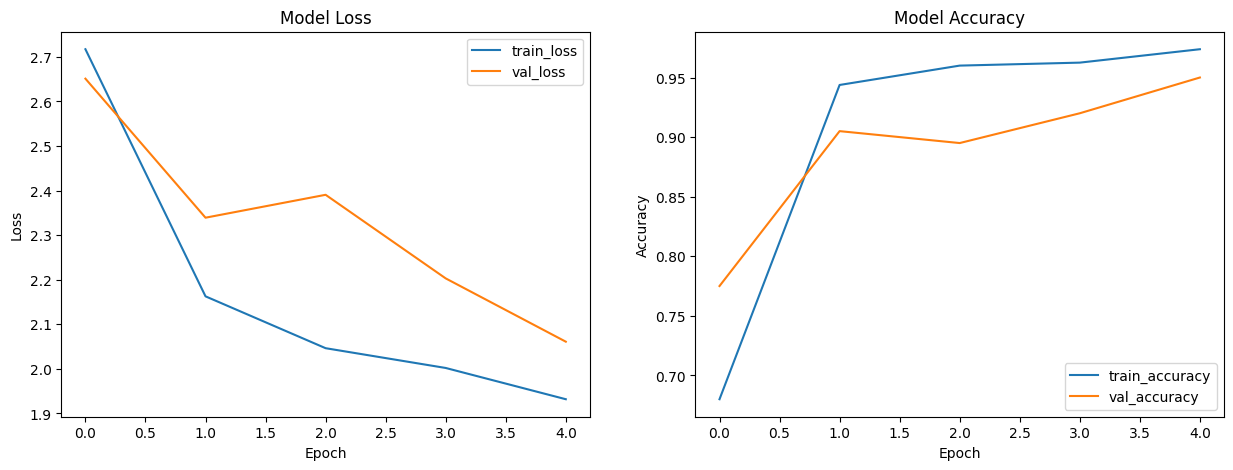

Fold 2
Epoch 1/5
25/25 [==============================] - 42s 504ms/step - loss: 2.7015 - accuracy: 0.6975 - val_loss: 2.6233 - val_accuracy: 0.7200
Epoch 2/5
25/25 [==============================] - 11s 462ms/step - loss: 2.2017 - accuracy: 0.9187 - val_loss: 2.3160 - val_accuracy: 0.9050
Epoch 3/5
25/25 [==============================] - 11s 459ms/step - loss: 2.0508 - accuracy: 0.9550 - val_loss: 2.1799 - val_accuracy: 0.9050
Epoch 4/5
25/25 [==============================] - 15s 618ms/step - loss: 2.0075 - accuracy: 0.9538 - val_loss: 2.0237 - val_accuracy: 0.9500
Epoch 5/5
13/13 [==============================] - 4s 286ms/step - loss: 1.9749 - accuracy: 0.9525
Validation accuracy for fold 2: 0.9524999856948853


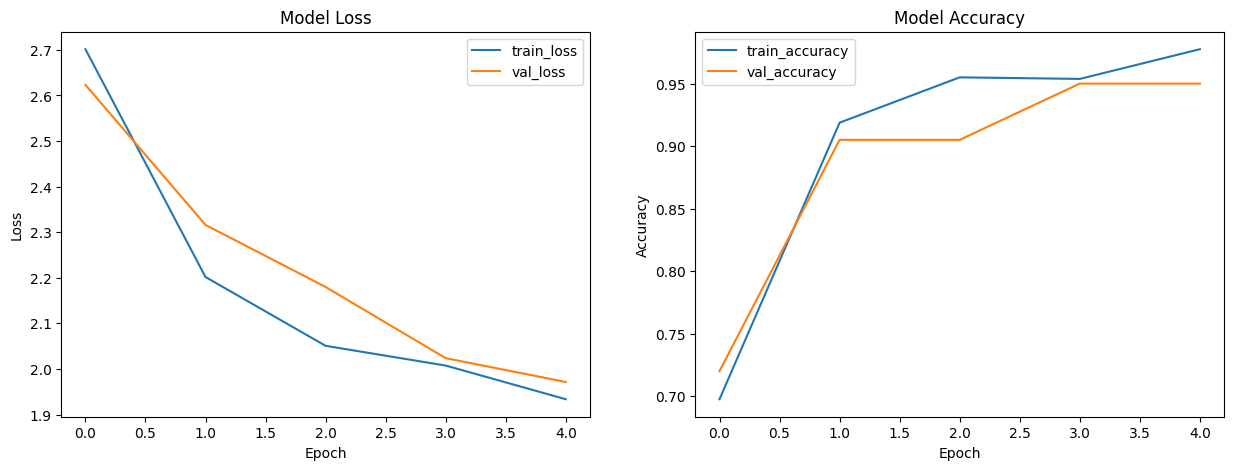

Fold 3
Epoch 1/5
25/25 [==============================] - 42s 502ms/step - loss: 2.8059 - accuracy: 0.6288 - val_loss: 2.5676 - val_accuracy: 0.7525
Epoch 2/5
25/25 [==============================] - 11s 459ms/step - loss: 2.2490 - accuracy: 0.9038 - val_loss: 2.3001 - val_accuracy: 0.8900
Epoch 3/5
25/25 [==============================] - 11s 458ms/step - loss: 2.0844 - accuracy: 0.9500 - val_loss: 2.1827 - val_accuracy: 0.9150
Epoch 4/5
25/25 [==============================] - 11s 458ms/step - loss: 2.0017 - accuracy: 0.9588 - val_loss: 2.1572 - val_accuracy: 0.9450
Epoch 5/5
13/13 [==============================] - 4s 282ms/step - loss: 2.0294 - accuracy: 0.9450
Validation accuracy for fold 3: 0.9449999928474426


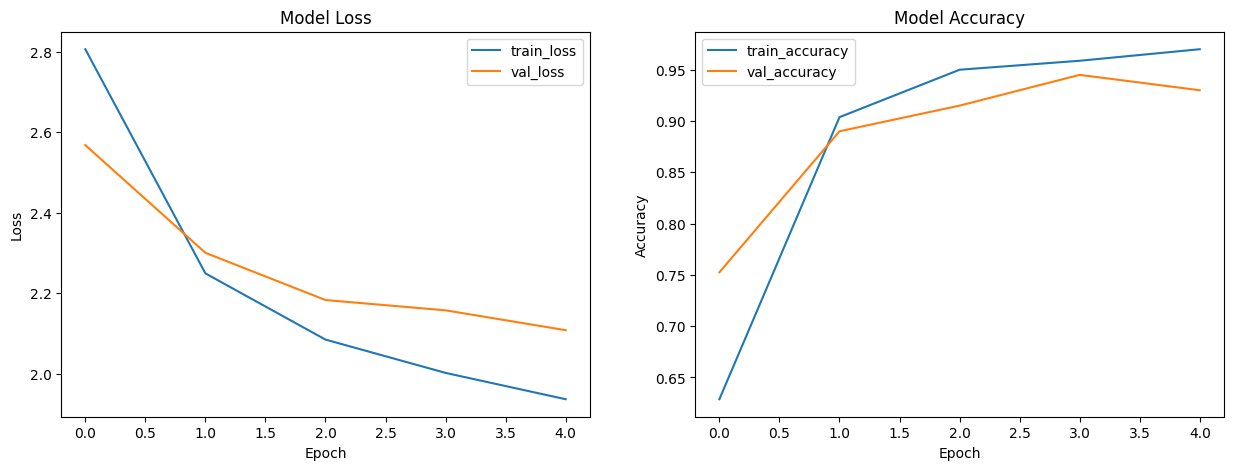

Mean validation accuracy: 0.9516666531562805


In [19]:
def build_model(l2_reg=0.001):
    base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(l2_reg), bias_regularizer=regularizers.l2(l2_reg))(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_reg), bias_regularizer=regularizers.l2(l2_reg))(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Define the data augmentation parameters
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)


# Define the cross-validation splits
cv = KFold(n_splits=3, shuffle=True, random_state=42)

fit_params = {
    'batch_size': 16,
    'epochs': 5,
    'verbose': 1,
    'callbacks': [
        EarlyStopping(monitor='val_loss', min_delta=0.01,mode = 'min',
  patience=5,verbose = 0, restore_best_weights = True),
        ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)]
}

# Train and validate the model on each fold
val_accs = []
for i, (train_index, val_index) in enumerate(cv.split(train_data, train_labels)):
    print(f'Fold {i + 1}')
    train_generator = datagen.flow(train_data[train_index], train_labels[train_index])
    val_generator = datagen.flow(train_data[val_index], train_labels[val_index])

    res_model = build_model()
    history = res_model.fit(train_generator, validation_data=val_generator, **fit_params)

    val_acc = res_model.evaluate(val_generator)[1]
    val_accs.append(val_acc)
    print(f'Validation accuracy for fold {i + 1}: {val_acc}')
    plot_loss_and_accuracy(history)

print(f'Mean validation accuracy: {np.mean(val_accs)}')


Test loss: 2.5577316284179688
Test accuracy: 0.8462733030319214
81/81 [==============================] - 2s 10ms/step
              precision    recall  f1-score   support

      NORMAL       0.25      0.40      0.31       317
   PNEUMONIA       0.66      0.52      0.58       855
     COVID19       0.09      0.09      0.09       116

    accuracy                           0.45      1288
   macro avg       0.34      0.34      0.33      1288
weighted avg       0.51      0.45      0.47      1288



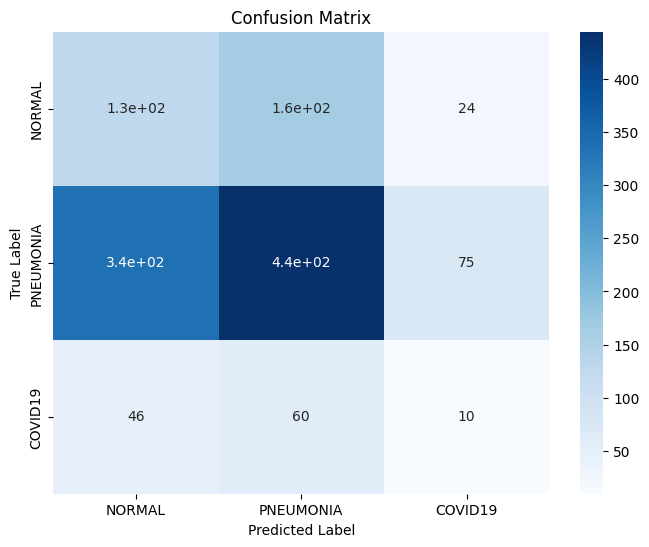

In [20]:
datagen = ImageDataGenerator(rescale=1./255)

test_generator = datagen.flow(test_data, test_labels, batch_size=BATCH_SIZE)

# Evaluate the model on the test set
test_loss, test_acc = res_model.evaluate(test_generator, verbose=0)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

# Use the model to predict the class probabilities for each image in the test set
y_pred = res_model.predict(test_generator)

# Convert the class probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = np.argmax(test_labels, axis=1)

# Get the class names
class_names = list(label_map.keys())

# Print the classification report
print(classification_report(y_true, y_pred_labels, target_names=class_names))

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def visualize_predictions(images, true_labels, pred_labels, class_names, nrows=4, ncols=4):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))
    axs = axs.ravel()

    for i in range(nrows * ncols):
        img = images[i]
        label = true_labels[i]
        pred_label = pred_labels[i]

        # Reshape images to 2D arrays
        img_flat = img.reshape(-1, 1)

        # Normalize the pixel values in the image array
        scaler = MinMaxScaler()
        img_norm = scaler.fit_transform(np.float32(img_flat))

        # Reshape images back to 3D arrays
        img_norm = img_norm.reshape(img.shape[0], img.shape[1], img.shape[2])

        # Check if the image is misclassified and set title color accordingly
        title_color = 'red' if label != pred_label else 'black'

        axs[i].imshow(img_norm)
        axs[i].set_title(f'{class_names[label]} - {class_names[pred_label]}', color=title_color)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


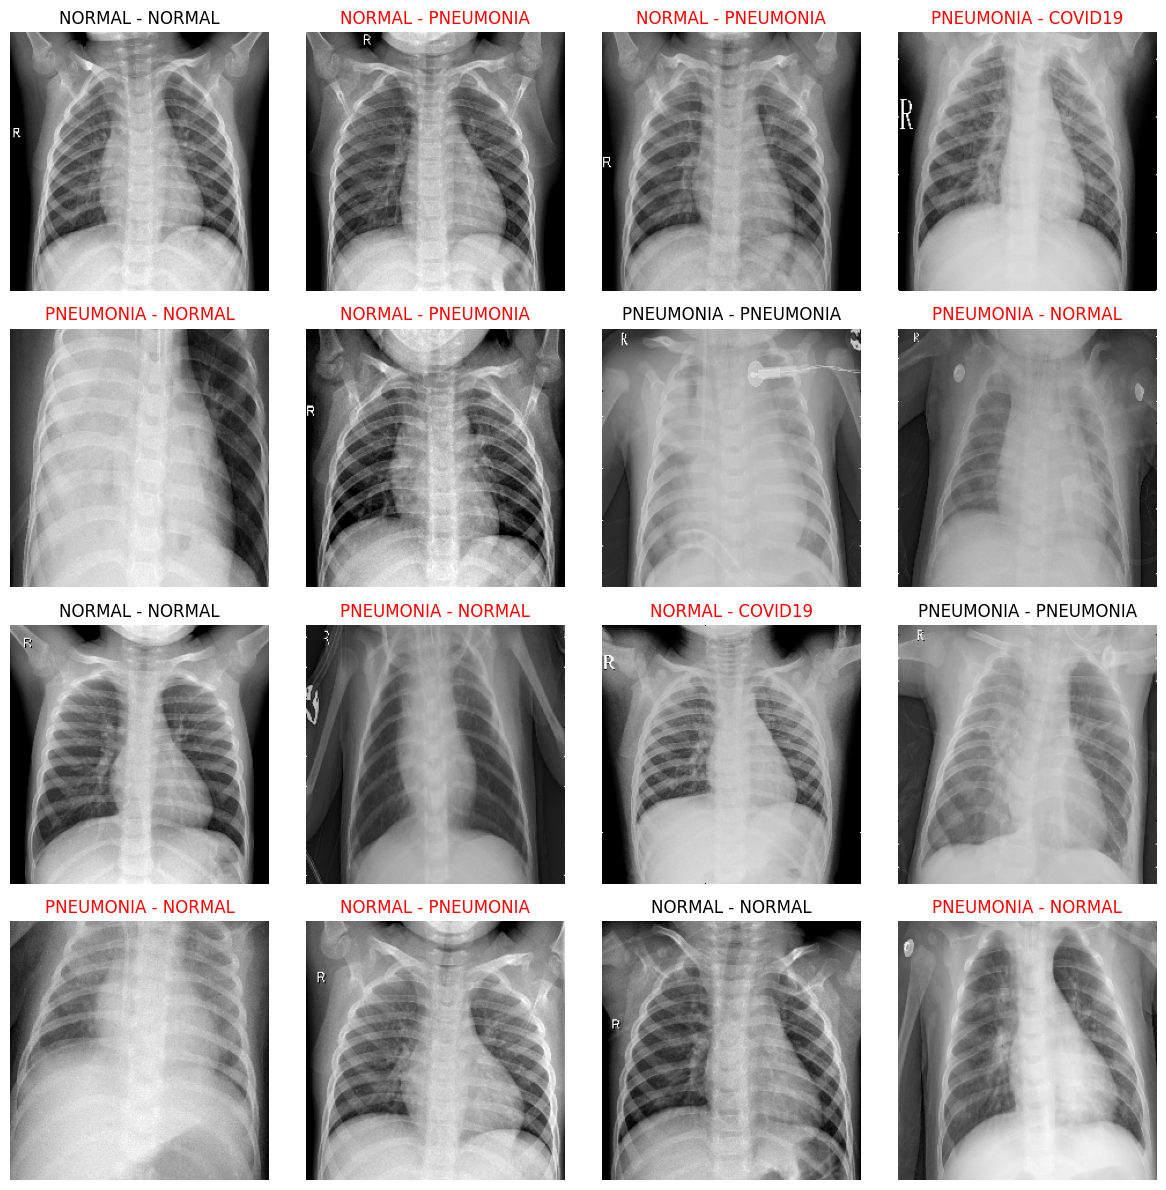

In [22]:
# Visualize a random subset of test data and their predicted labels
indices = np.random.choice(len(test_data), 16, replace=False)
images = test_data[indices]
true_labels = y_true[indices]
pred_labels = y_pred_labels[indices]

visualize_predictions(images, true_labels, pred_labels, class_names)

### InceptionResNetV2 Model

Fold 1
219055592/219055592 [==============================] - 10s 0us/step
Epoch 1/5
25/25 [==============================] - 116s 950ms/step - loss: 2.7101 - accuracy: 0.6237 - val_loss: 3.3107 - val_accuracy: 0.6075
Epoch 2/5
25/25 [==============================] - 12s 460ms/step - loss: 2.0986 - accuracy: 0.9350 - val_loss: 3.4739 - val_accuracy: 0.6850
Epoch 3/5
25/25 [==============================] - 21s 862ms/step - loss: 1.9503 - accuracy: 0.9625 - val_loss: 2.6810 - val_accuracy: 0.8050
Epoch 4/5
25/25 [==============================] - 17s 678ms/step - loss: 1.8953 - accuracy: 0.9625 - val_loss: 2.3734 - val_accuracy: 0.8225
Epoch 5/5
13/13 [==============================] - 4s 287ms/step - loss: 2.2302 - accuracy: 0.8675
Validation accuracy for fold 1: 0.8675000071525574


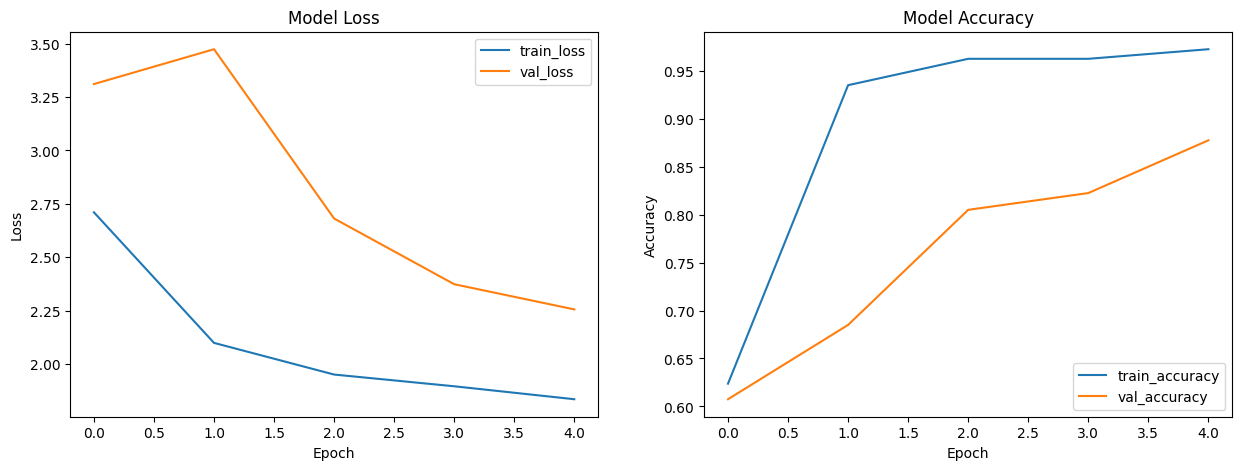

Fold 2
Epoch 1/5
25/25 [==============================] - 105s 626ms/step - loss: 2.7115 - accuracy: 0.6400 - val_loss: 2.6414 - val_accuracy: 0.6900
Epoch 2/5
25/25 [==============================] - 12s 469ms/step - loss: 2.0628 - accuracy: 0.9388 - val_loss: 2.4863 - val_accuracy: 0.8400
Epoch 3/5
25/25 [==============================] - 21s 850ms/step - loss: 1.9048 - accuracy: 0.9712 - val_loss: 2.0367 - val_accuracy: 0.9550
Epoch 4/5
25/25 [==============================] - 12s 464ms/step - loss: 1.8553 - accuracy: 0.9750 - val_loss: 2.0486 - val_accuracy: 0.9500
Epoch 5/5
13/13 [==============================] - 4s 285ms/step - loss: 1.9287 - accuracy: 0.9575
Validation accuracy for fold 2: 0.9574999809265137


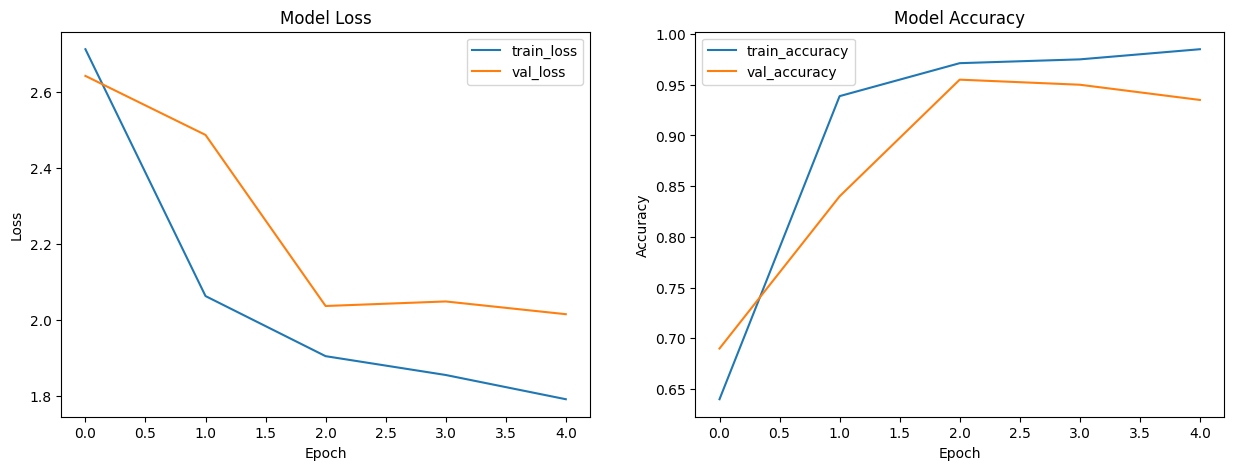

Fold 3
Epoch 1/5
25/25 [==============================] - 105s 618ms/step - loss: 2.7279 - accuracy: 0.6175 - val_loss: 2.9356 - val_accuracy: 0.6050
Epoch 2/5
25/25 [==============================] - 12s 471ms/step - loss: 2.1536 - accuracy: 0.9100 - val_loss: 2.7099 - val_accuracy: 0.8150
Epoch 3/5
25/25 [==============================] - 12s 475ms/step - loss: 1.9881 - accuracy: 0.9488 - val_loss: 2.4558 - val_accuracy: 0.8375
Epoch 4/5
25/25 [==============================] - 21s 859ms/step - loss: 1.8755 - accuracy: 0.9712 - val_loss: 2.0146 - val_accuracy: 0.9450
Epoch 5/5
13/13 [==============================] - 4s 286ms/step - loss: 1.8754 - accuracy: 0.9600
Validation accuracy for fold 3: 0.9599999785423279


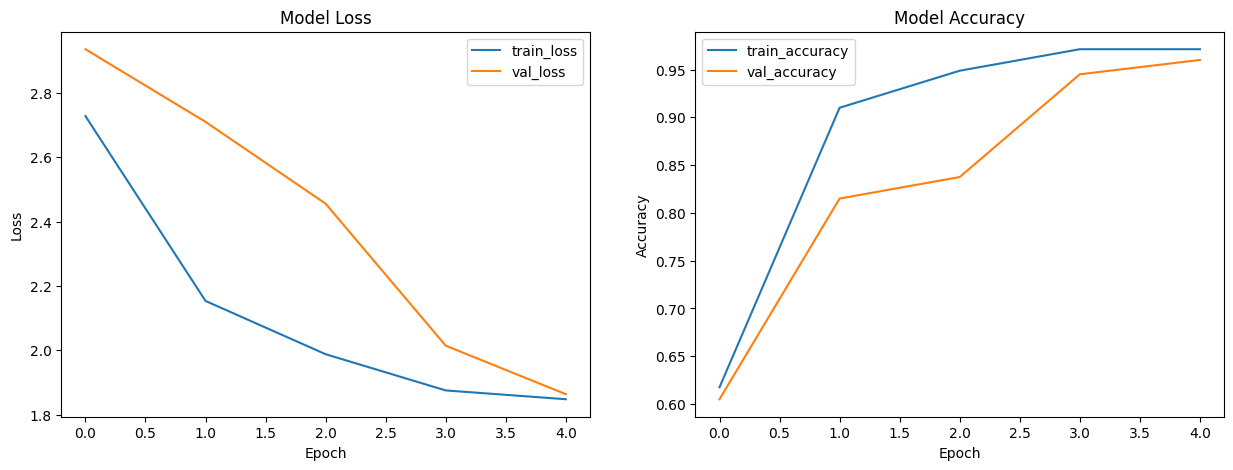

Mean validation accuracy: 0.9283333222071329


In [23]:
def build_model(l2_reg=0.001):
    base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(l2_reg), bias_regularizer=regularizers.l2(l2_reg))(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_reg), bias_regularizer=regularizers.l2(l2_reg))(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Define the data augmentation parameters
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)


# Define the cross-validation splits
cv = KFold(n_splits=3, shuffle=True, random_state=42)

fit_params = {
    'batch_size': 16,
    'epochs': 5,
    'verbose': 1,
    'callbacks': [
        EarlyStopping(monitor='val_loss', min_delta=0.01,mode = 'min',
  patience=5, restore_best_weights = True),
        ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)]
}

# Train and validate the model on each fold
val_accs = []
for i, (train_index, val_index) in enumerate(cv.split(train_data, train_labels)):
    print(f'Fold {i + 1}')
    train_generator = datagen.flow(train_data[train_index], train_labels[train_index])
    val_generator = datagen.flow(train_data[val_index], train_labels[val_index])

    inc_model = build_model()
    history = inc_model.fit(train_generator, validation_data=val_generator, **fit_params)

    val_acc = inc_model.evaluate(val_generator)[1]
    val_accs.append(val_acc)
    print(f'Validation accuracy for fold {i + 1}: {val_acc}')
    plot_loss_and_accuracy(history)

print(f'Mean validation accuracy: {np.mean(val_accs)}')


Test loss: 2.0714662075042725
Test accuracy: 0.9324533939361572
81/81 [==============================] - 5s 22ms/step
              precision    recall  f1-score   support

      NORMAL       0.22      0.25      0.23       317
   PNEUMONIA       0.65      0.63      0.64       855
     COVID19       0.09      0.08      0.08       116

    accuracy                           0.49      1288
   macro avg       0.32      0.32      0.32      1288
weighted avg       0.49      0.49      0.49      1288



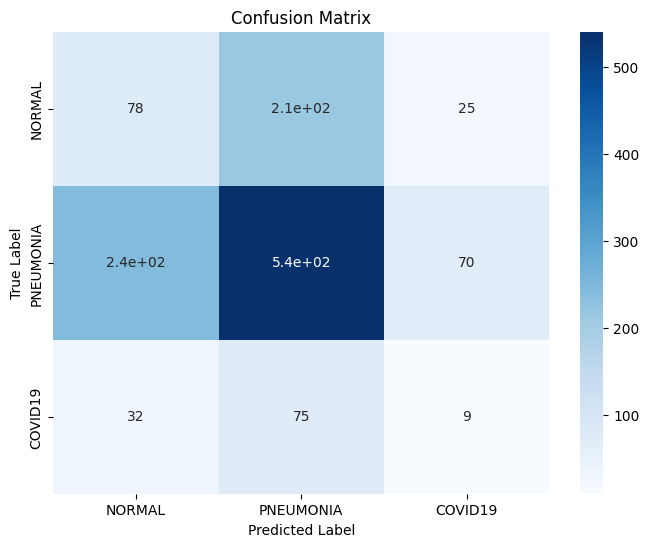

In [24]:
datagen = ImageDataGenerator(rescale=1./255)

test_generator = datagen.flow(test_data, test_labels, batch_size=BATCH_SIZE)

# Evaluate the model on the test set
test_loss, test_acc = inc_model.evaluate(test_generator, verbose=0)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

# Use the model to predict the class probabilities for each image in the test set
y_pred = inc_model.predict(test_generator)

# Convert the class probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the true labels
y_true = np.argmax(test_labels, axis=1)

# Get the class names
class_names = list(label_map.keys())

# Print the classification report
print(classification_report(y_true, y_pred_labels, target_names=class_names))

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



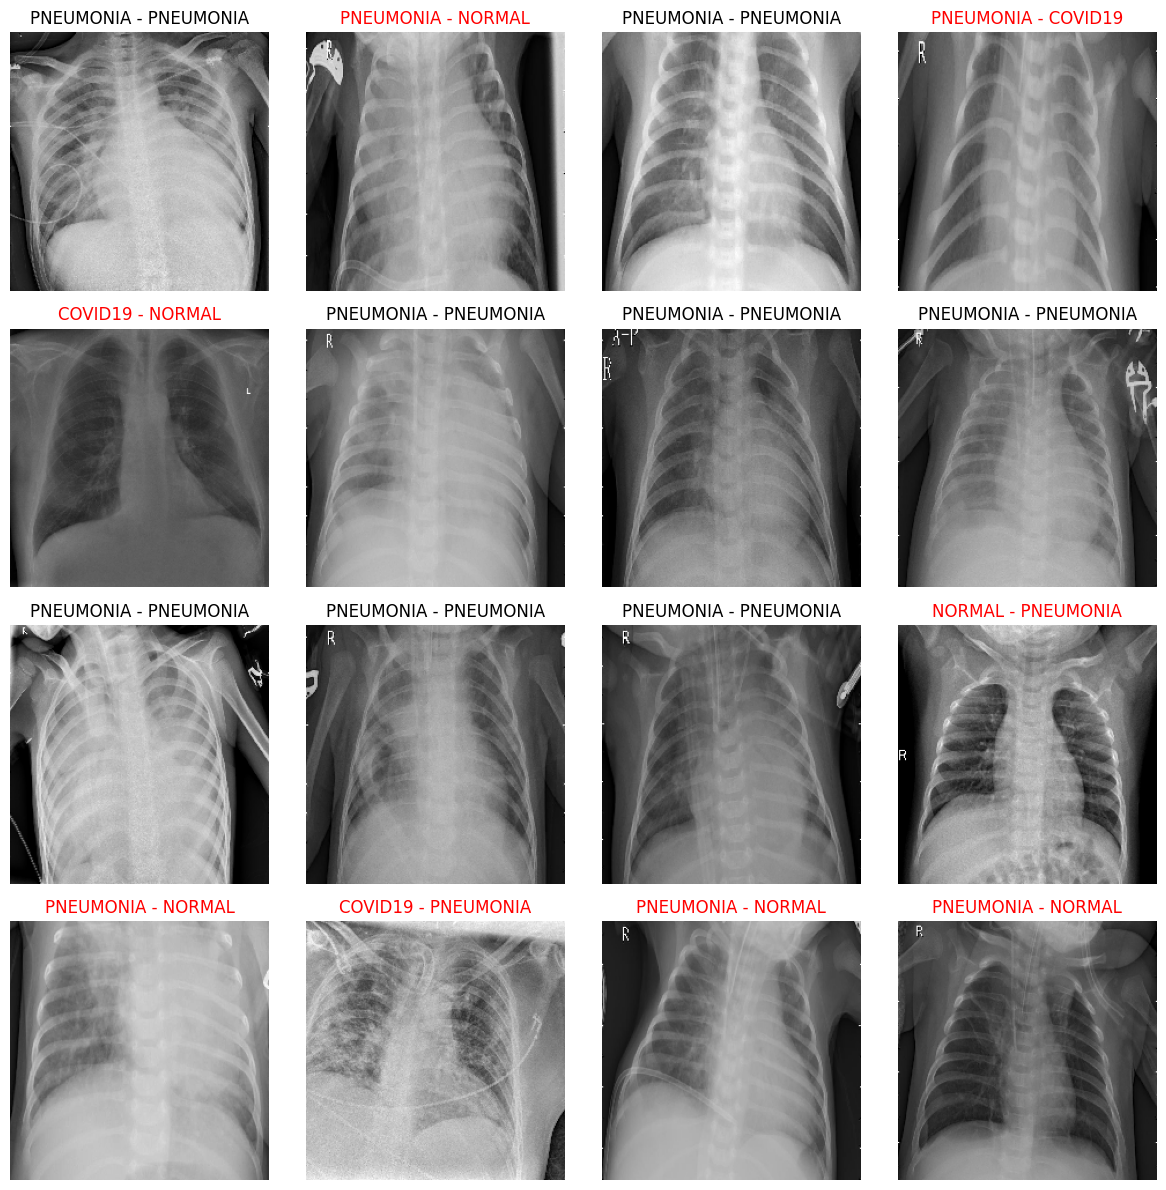

In [25]:
# Visualizes a random subset of test data and their predicted labels
indices = np.random.choice(len(test_data), 16, replace=False)
images = test_data[indices]
true_labels = y_true[indices]
pred_labels = y_pred_labels[indices]

visualize_predictions(images, true_labels, pred_labels, class_names)